In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch.nn as nn
import os


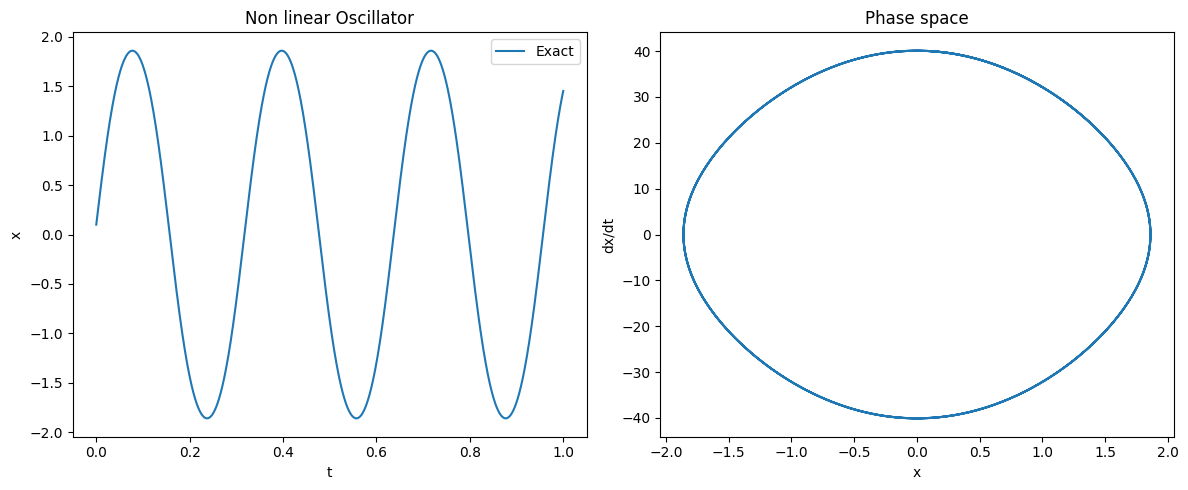

In [3]:
# Define the funtion of no linear oscillator
def ode(r, t, omega):
    x, v = r
    dxdt = v
    dvdt = -omega**2 * np.sin(x)
    return [dxdt, dvdt]

# Parameters

omega = 25
tMin, tMax = 0.0, 1.
nSteps = 10000
tPoints = np.linspace(tMin, tMax, nSteps)

# Initial conditions
r0 = [0.1, 40.]

# Analytic Solution
sol = odeint(ode, r0, tPoints, args=(omega, ))
xPoints = sol[:, 0]
vPoints = sol[:, 1]

# plot solution

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

axes[0].plot(tPoints, xPoints, label="Exact")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x")
axes[0].set_title("Non linear Oscillator")
axes[0].legend()

axes[1].plot(xPoints, vPoints)
axes[1].set_xlabel("x")
axes[1].set_ylabel("dx/dt")
axes[1].set_title("Phase space")

plt.tight_layout()
plt.show()


In [4]:
# Neural Network (fully conected network)

class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, num_layers):
        super().__init__()
        self.input_layer = nn.Sequential(*[
                    nn.Linear(in_dim, hidden_dim),
                    nn.Tanh()])
        self.hidden_layers = nn.Sequential(*[
                    nn.Sequential(*[
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.Tanh()])
                    for _ in range(num_layers-1)])
        self.output_layer = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
        


In [5]:
# Convert data to PyTorch tensors (subsampling)
x_tensor = torch.tensor(tPoints, dtype=torch.float32).view(-1,1)
y_tensor = torch.tensor(xPoints, dtype=torch.float32).view(-1,1)

# reduce by slicing (one point over 10)
x = x_tensor[::10]
y = y_tensor[::10]

# Data to training
x_data = x_tensor[0:500:400]
y_data = y_tensor[0:500:400]

Epoch 500, Loss: 0.03762149438261986
Epoch 1000, Loss: 0.024685688316822052
Epoch 1500, Loss: 0.019707832485437393
Epoch 2000, Loss: 0.017738213762640953
Epoch 2500, Loss: 0.01590561494231224
Epoch 3000, Loss: 0.01510128378868103
Epoch 3500, Loss: 0.012757905758917332
Epoch 4000, Loss: 0.00917862169444561
Epoch 4500, Loss: 0.008713111281394958
Epoch 5000, Loss: 0.008440735749900341


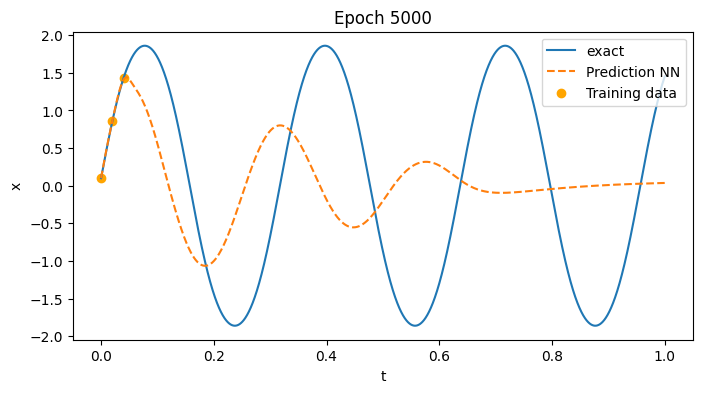

Epoch 5500, Loss: 0.008755508810281754
Epoch 6000, Loss: 0.008169474080204964


KeyboardInterrupt: 

In [30]:
torch.manual_seed(123)
model = FCN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_data = []
loss_physics1 = []
loss_history = []
mse_history = []

# Define collocation points to enforce the ODE
x_physics = torch.linspace(tMin, tMax, 40).view(-1,1).requires_grad_(True)

# Define dense domain to visualize solution
x_plot = torch.linspace(tMin, tMax, 1000).view(-1,1)

for epoch in range(50000):
    optimizer.zero_grad()
    
    # Data loss
    y_pred_data = model(x_data)
    loss_data = 1.*torch.mean((y_pred_data - y_data)**2)  # MSE
    
    # Physics loss
    y_pred_physics = model(x_physics)
    dy_dx = torch.autograd.grad(y_pred_physics, x_physics, torch.ones_like(y_pred_physics), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_physics, torch.ones_like(dy_dx), create_graph=True)[0]
    physics_residual = d2y_dx2 + omega**2 * torch.sin(y_pred_physics)
    loss_physics = 3e-6 * torch.mean(physics_residual**2)
    
    # backpropagate 
    loss = loss_data + loss_physics
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    
    # Plot result 
    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        # Obtain prediction over domain
        y_plot = model(x_plot).detach().numpy()
        xp = x_physics.detach()
        
        plt.figure(figsize=(8,4))
        plt.plot(tPoints, xPoints, label="exact")
        plt.plot(x_plot.numpy(), y_plot, '--', label="Prediction NN")
        plt.scatter(x_data.numpy(), y_data.numpy(), color="orange", label="Training data")
        plt.xlabel("t")
        plt.ylabel("x")
        plt.title(f"Epoch {epoch+1}")
        plt.legend()
        plt.savefig(f"frame_{epoch+1:05d}.png")
        if (epoch+1) % 5000 == 0: plt.show()
        else: plt.close()



In [11]:
# Parámetros para barrido
layers_list = [2, 3, 4, 5]
data_training_list = [1, 2, 3]

# Loop sobre combinaciones de datos de entrenamiento y capas ocultas
for data_training in data_training_list:
    for num_layers in layers_list:
        # Crear carpeta para guardar resultados
        folder_name = f"results_data{data_training}_layers{num_layers}"
        os.makedirs(folder_name, exist_ok=True)

        # Seleccionar subconjunto de datos de entrenamiento
        step = 1000 // data_training
        x_data = x_tensor[0:1000:step]
        y_data = y_tensor[0:1000:step]

        # Inicializar modelo y optimizador
        torch.manual_seed(123)
        model = FCN(1, 1, 32, num_layers)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_history = []

        # Puntos de colisión para la ODE
        x_physics = torch.linspace(tMin, tMax, 40).view(-1,1).requires_grad_(True)
        x_plot = torch.linspace(tMin, tMax, 1000).view(-1,1)

        # Entrenamiento
        for epoch in range(50000):
            optimizer.zero_grad()

            # Pérdida de datos
            y_pred_data = model(x_data)
            loss_data = torch.mean((y_pred_data - y_data) ** 2)

            # Pérdida de la física
            y_pred_physics = model(x_physics)
            dy_dx = torch.autograd.grad(y_pred_physics, x_physics, torch.ones_like(y_pred_physics), create_graph=True)[0]
            d2y_dx2 = torch.autograd.grad(dy_dx, x_physics, torch.ones_like(dy_dx), create_graph=True)[0]
            physics_residual = d2y_dx2 + omega ** 2 * torch.sin(y_pred_physics)
            loss_physics = 3e-6 * torch.mean(physics_residual ** 2)

            # Propagación hacia atrás
            loss = loss_data + loss_physics
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

            # Guardar imágenes cada 500 épocas
            if (epoch + 1) % 500 == 0:
                #print(f"Data {data_training}, Layers {num_layers}, Epoch {epoch+1}, Loss: {loss.item()}")

                # Predicción sobre dominio
                y_plot = model(x_plot).detach().numpy()

                # Graficar resultados
                plt.figure(figsize=(8, 4))
                plt.plot(tPoints, xPoints, label="Exact")
                plt.plot(x_plot.numpy(), y_plot, '--', label="Prediction NN")
                plt.scatter(x_data.numpy(), y_data.numpy(), color="orange", label="Training data")
                plt.xlabel("t")
                plt.ylabel("x")
                plt.title(f"Epoch {epoch+1}")
                plt.legend()
                plt.savefig(f"{folder_name}/frame_{epoch+1:05d}.png")
                #if (epoch+1) % 5000 == 0:
                    #plt.show()
                #else:
                plt.close()


        print("\t Training | layers: ", num_layers , "\t # Data:", data_training)
        plt.figure()
        plt.plot(loss_history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.savefig(f"{folder_name}/loss.png")
        plt.close()

print("Entrenamiento completado.")

	 Training | layers:  2 	 # Data: 1
	 Training | layers:  3 	 # Data: 1
	 Training | layers:  4 	 # Data: 1
	 Training | layers:  5 	 # Data: 1
	 Training | layers:  2 	 # Data: 2
	 Training | layers:  3 	 # Data: 2
	 Training | layers:  4 	 # Data: 2
	 Training | layers:  5 	 # Data: 2
	 Training | layers:  2 	 # Data: 3
	 Training | layers:  3 	 # Data: 3
	 Training | layers:  4 	 # Data: 3
	 Training | layers:  5 	 # Data: 3
Entrenamiento completado.


In [ ]:
!ffmpeg -r 10 -pattern_type glob -i "frame_*.png" -c:v libx264 -pix_fmt yuv420p training_1.mp4 -y > /dev/null 2>&1


In [12]:
# Parámetros para barrido
layers_list = [2, 3, 4, 5]
data_training_list = [1, 2, 3]

# Loop sobre combinaciones de datos de entrenamiento y capas ocultas
for data_training in data_training_list:
    for num_layers in layers_list:
        # Crear carpeta para guardar resultados
        folder_name = f"results_energy_data{data_training}_layers{num_layers}"
        os.makedirs(folder_name, exist_ok=True)

        # Seleccionar subconjunto de datos de entrenamiento
        step = 1000 // data_training
        x_data = x_tensor[0:1000:step]
        y_data = y_tensor[0:1000:step]

        # Inicializar modelo y optimizador
        torch.manual_seed(123)
        model = FCN(1, 1, 32, num_layers)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_history = []

        # Puntos de colisión para la ODE
        x_physics = torch.linspace(tMin, tMax, 40).view(-1,1).requires_grad_(True)
        x_plot = torch.linspace(tMin, tMax, 1000).view(-1,1)

        # Entrenamiento
        for epoch in range(50000):
            optimizer.zero_grad()

            # Pérdida de datos
            y_pred_data = model(x_data)
            loss_data = torch.mean((y_pred_data - y_data) ** 2)

            # Pérdida de la física
            y_pred_physics = model(x_physics)
            dy_dx = torch.autograd.grad(y_pred_physics, x_physics, torch.ones_like(y_pred_physics), create_graph=True)[0]
            d2y_dx2 = torch.autograd.grad(dy_dx, x_physics, torch.ones_like(dy_dx), create_graph=True)[0]
            physics_residual = d2y_dx2 + omega ** 2 * torch.sin(y_pred_physics)
            loss_physics = 3e-6 * torch.mean(physics_residual ** 2)
            # compute the "energy loss" (take into account the initial conditions for the cst)
            physics2= (dy_dx**2/2. - omega**2*torch.cos(y_pred_physics) + omega**2*np.cos(0.1) - 40*40/2. )
            loss_physics_2 = (3.e-7)*torch.mean(physics2**2)
            # backpropagate joint loss
            loss = loss_data + loss_physics + loss_physics_2
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

            # Guardar imágenes cada 500 épocas
            if (epoch + 1) % 500 == 0:
                #print(f"Data {data_training}, Layers {num_layers}, Epoch {epoch+1}, Loss: {loss.item()}")

                # Predicción sobre dominio
                y_plot = model(x_plot).detach().numpy()

                # Graficar resultados
                plt.figure(figsize=(8, 4))
                plt.plot(tPoints, xPoints, label="Exact")
                plt.plot(x_plot.numpy(), y_plot, '--', label="Prediction NN")
                plt.scatter(x_data.numpy(), y_data.numpy(), color="orange", label="Training data")
                plt.xlabel("t")
                plt.ylabel("x")
                plt.title(f"Epoch {epoch+1}")
                plt.legend()
                plt.savefig(f"{folder_name}/frame_{epoch+1:05d}.png")
                #if (epoch+1) % 5000 == 0:
                    #plt.show()
                #else:
                plt.close()
        print("\t Training | layers: ", num_layers , "\t # Data:", data_training)
        plt.figure()
        plt.plot(loss_history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.savefig(f"{folder_name}/loss.png")
        plt.close()
print("Entrenamiento completado.")

	 Training | layers:  2 	 # Data: 1


KeyboardInterrupt: 

# ODE SYSTEM FOR NON-LINEAR OSCILLATOR
The pendulum system is given by:



\begin{aligned}
    \frac{dy_1}{dt} - \omega_0 y_2 &= 0 \\
    \frac{dy_2}{dt} + \omega_0 \sin(y_1) &= 0
\end{aligned}

Where:
- \( y_1 \) represents the pendulum angle.
- \( y_2 \) represents the angular velocity.
- \( w \) is the angular frequency.



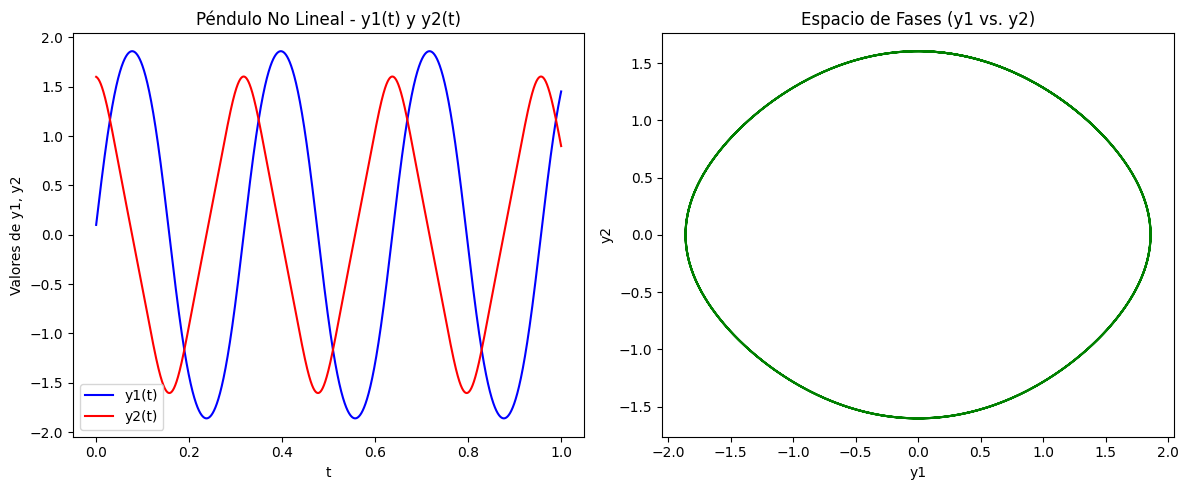

In [6]:
def pendulum_system(r, t, w):
    """
    r = [y1, y2]
    dy1/dt = y2
    dy2/dt = - w^2 * sin(y1)
    """
    y1, y2 = r
    dy1dt = w*y2
    dy2dt = -w * np.sin(y1)
    return [dy1dt, dy2dt]

# Parámetros
omega = 25.0
tMin, tMax = 0.0, 1.0
nSteps = 10000
tPoints = np.linspace(tMin, tMax, nSteps)

# Condiciones iniciales
r0 = [0.1, 1.6]  # y1(0) = 0.1, y2(0) = 1.6

# Resolver con odeint
sol = odeint(pendulum_system, r0, tPoints, args=(omega,))
y1Points = sol[:, 0]  # y1(t)
y2Points = sol[:, 1]  # y2(t)

# Graficar la solución de referencia
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graficar y1(t) y y2(t) en el mismo subplot
axes[0].plot(tPoints, y1Points, label="y1(t)", color='blue')
axes[0].plot(tPoints, y2Points, label="y2(t)", color='red')
axes[0].set_xlabel("t")
axes[0].set_ylabel("Valores de y1, y2")
axes[0].set_title("Péndulo No Lineal - y1(t) y y2(t)")
axes[0].legend()

# Graficar espacio de fases
axes[1].plot(y1Points, y2Points, color='green')
axes[1].set_xlabel("y1")
axes[1].set_ylabel("y2")
axes[1].set_title("Espacio de Fases (y1 vs. y2)")

# Ajustar el diseño
plt.tight_layout()
plt.show()

Energía inicial: 178.1224
Epoch 5000, Loss: 1.55978e+00
Epoch 10000, Loss: 1.56696e-01
Epoch 15000, Loss: 2.78712e-02
Epoch 20000, Loss: 7.67494e-04
Epoch 25000, Loss: 4.23453e-04
Epoch 30000, Loss: 2.81884e-04
Epoch 35000, Loss: 1.01950e-03
Epoch 40000, Loss: 4.65952e-04
Epoch 45000, Loss: 1.00905e-04
Epoch 50000, Loss: 7.73709e-05
Epoch 55000, Loss: 6.95113e-04
Epoch 60000, Loss: 5.14436e-05


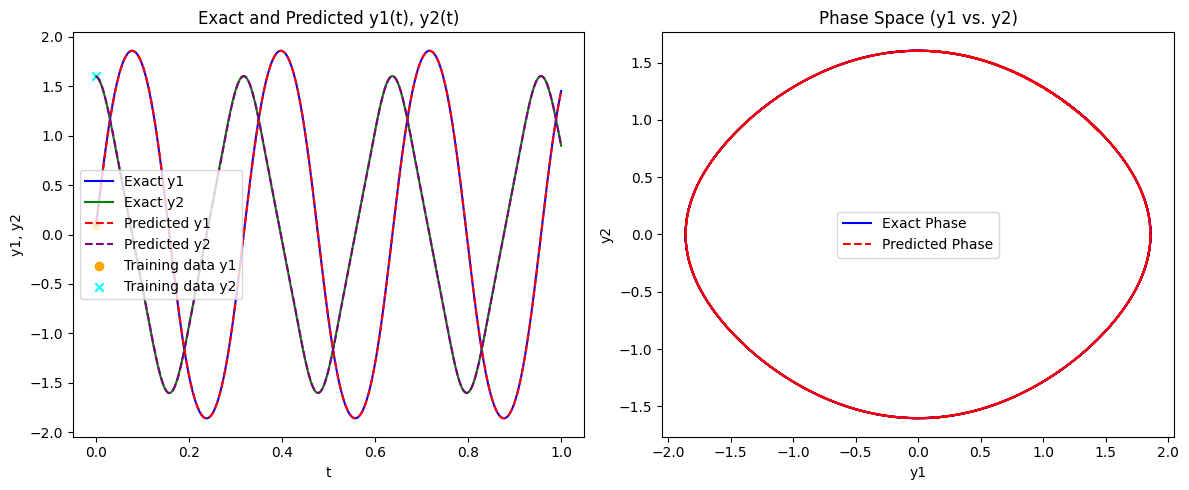

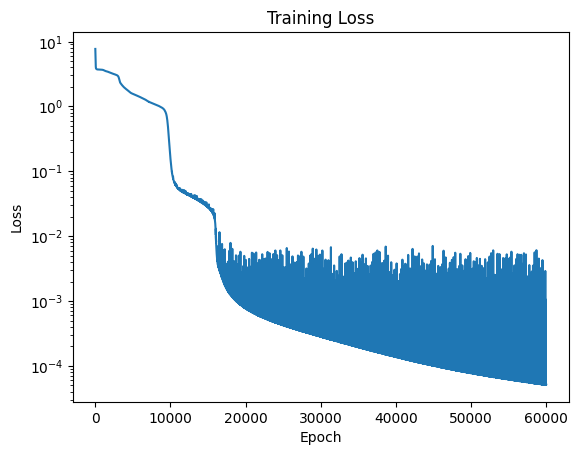

In [17]:
t_torch = torch.tensor(tPoints, dtype=torch.float32).view(-1,1)
y1_torch = torch.tensor(y1Points, dtype=torch.float32).view(-1,1)
y2_torch = torch.tensor(y2Points, dtype=torch.float32).view(-1,1)

# Queremos SOLO el punto inicial: t=0
x_data = torch.tensor([[0.0]], dtype=torch.float32)  # shape [1,1]
y1_data = torch.tensor([[0.1]], dtype=torch.float32) # y1(0)=0.1
y2_data = torch.tensor([[1.6]], dtype=torch.float32) # y2(0)=1.6

# --------------------------------------------------------
# 4) Instanciar modelo y optimizador
# --------------------------------------------------------
model = FCN(in_dim=1, out_dim=2, hidden_dim=32, num_layers=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=20)

# Puntos de colocación (collocation points) para imponer la ecuación
x_physics = torch.linspace(tMin, tMax, 40).view(-1,1).requires_grad_(True)

loss_history = []
E_init = omega**2 * ( (1.6**2)/2. ) - omega**2 * np.cos(0.1)
print(f"Energía inicial: {E_init:.4f}")

# --------------------------------------------------------
# 5) Entrenamiento de la PINN
# --------------------------------------------------------
for epoch in range(60000):
    optimizer.zero_grad()

    # (A) Data Loss: forzamos la red a cumplir y1(0)=0.1, y2(0)=1.6
    y_pred_data = model(x_data)   # [1,2]
    y1_pred_data = y_pred_data[:, 0:1]
    y2_pred_data = y_pred_data[:, 1:2]
    loss_data = torch.mean((y1_pred_data - y1_data)**2) + \
                torch.mean((y2_pred_data - y2_data)**2)

    # (B) Physics Loss:  dy1/dt = w*y2,  dy2/dt = -w*sin(y1)
    y_pred_phys = model(x_physics)  # shape [40,2]
    y1_pred_phys = y_pred_phys[:, 0:1]
    y2_pred_phys = y_pred_phys[:, 1:2]

    dy1_dt = torch.autograd.grad(y1_pred_phys, x_physics,
                                 torch.ones_like(y1_pred_phys),
                                 create_graph=True)[0]
    dy2_dt = torch.autograd.grad(y2_pred_phys, x_physics,
                                 torch.ones_like(y2_pred_phys),
                                 create_graph=True)[0]

    physics1 = dy1_dt - omega*y2_pred_phys
    physics2 = dy2_dt + omega*torch.sin(y1_pred_phys)
    loss_physics = 1e-1* (torch.mean(physics1**2) + torch.mean(physics2**2))

    # (C) Energy Loss: E(t) ~ E(0)
    E_current = omega**2 * (0.5 * y2_pred_phys**2) - omega**2 * torch.cos(y1_pred_phys)
    E_diff = E_current - E_init
    loss_energy = 2e-6 * torch.mean(E_diff**2)

    # (D) Pérdida total
    loss = loss_data + loss_physics + loss_energy
    loss.backward()
    optimizer.step()


    loss_history.append(loss.item())
    if (epoch+1) % 5000 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.5e}")

# ----
# --------------------------------------------------------
# 6) Validación y visualización de resultados
# --------------------------------------------------------
t_eval = torch.linspace(tMin, tMax, 1000).view(-1,1)
y_eval = model(t_eval).detach().numpy()

y1_eval = y_eval[:, 0]
y2_eval = y_eval[:, 1]

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Primer subplot: y1(t) y y2(t) en la misma gráfica
axes[0].plot(tPoints, y1Points, label='Exact y1', color='blue')
axes[0].plot(tPoints, y2Points, label='Exact y2', color='green')
axes[0].plot(t_eval.numpy(), y1_eval, '--', label='Predicted y1', color='red')
axes[0].plot(t_eval.numpy(), y2_eval, '--', label='Predicted y2', color='purple')
axes[0].scatter(x_data.detach().numpy(), y1_data.detach().numpy(),
                color='orange', label='Training data y1', marker='o')
axes[0].scatter(x_data.detach().numpy(), y2_data.detach().numpy(),
                color='cyan', label='Training data y2', marker='x')
axes[0].legend()
axes[0].set_xlabel('t')
axes[0].set_ylabel('y1, y2')
axes[0].set_title("Exact and Predicted y1(t), y2(t)")

# Segundo subplot: Espacio de fases
axes[1].plot(y1Points, y2Points, label='Exact Phase', color='blue')
axes[1].plot(y1_eval, y2_eval, '--', label='Predicted Phase', color='red')
axes[1].legend()
axes[1].set_xlabel('y1')
axes[1].set_ylabel('y2')
axes[1].set_title("Phase Space (y1 vs. y2)")

# Ajustar diseño para evitar solapamientos
plt.tight_layout()
plt.show()


# Finalmente, graficamos la historia de la pérdida
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
